# Automated counting of budding yeast meiotic cells 

## By Julie Rojas, Munich, Germany.

### Background:

During my PhD project, I developed an assay to assess the SAC (spindle assembly checkpoint) during meiosis in budding yeast. For that, we tagged the SAC protein Mad2 with the green fluorescent GFP. To determine at which stage of the meiotic program each cell is at a specific time point, we simultaneously followed the equivalent of centrosomes in budding yeast, the spindle pole bodies (SPBs), by tagging the SPBs protein Cnm67 with the red fluorescent protein RFP. 

Cells start meiosis with a single SPB. When cells enter metaphase I, two SPBs are observed and as cells enter anaphase I, the two SPBs get further apart. As cells enter metaphase II, SPBs are re-duplicated and appear as four dots. Hence, following SPB numbers through meiosis indicates entry into metaphase I and, later, entry into metaphase II. In wild-type cells, Mad2-GFP forms a diffuse nuclear signal until metaphase I onset when it forms bright cluster(s) in the vicinity of the SPBs. On average, these foci persist for 16 minutes before they disappear. Mad2-GFP clusters form again at metaphase II for 10 minutes on average. The picture inserted bellow show the progression of a representative cell progressing through meiosis and the manual countings of a 100 cells.

### Projects:

We aquired cells every 10 minutes for several hours and count for each cell at which time points we observe 2 SPBs and 4 SPBs as well as the time points in which Mad2-GFP clusters are observed. Instead of counting every cells manually, this project aim at developing a script to count cell automatically.

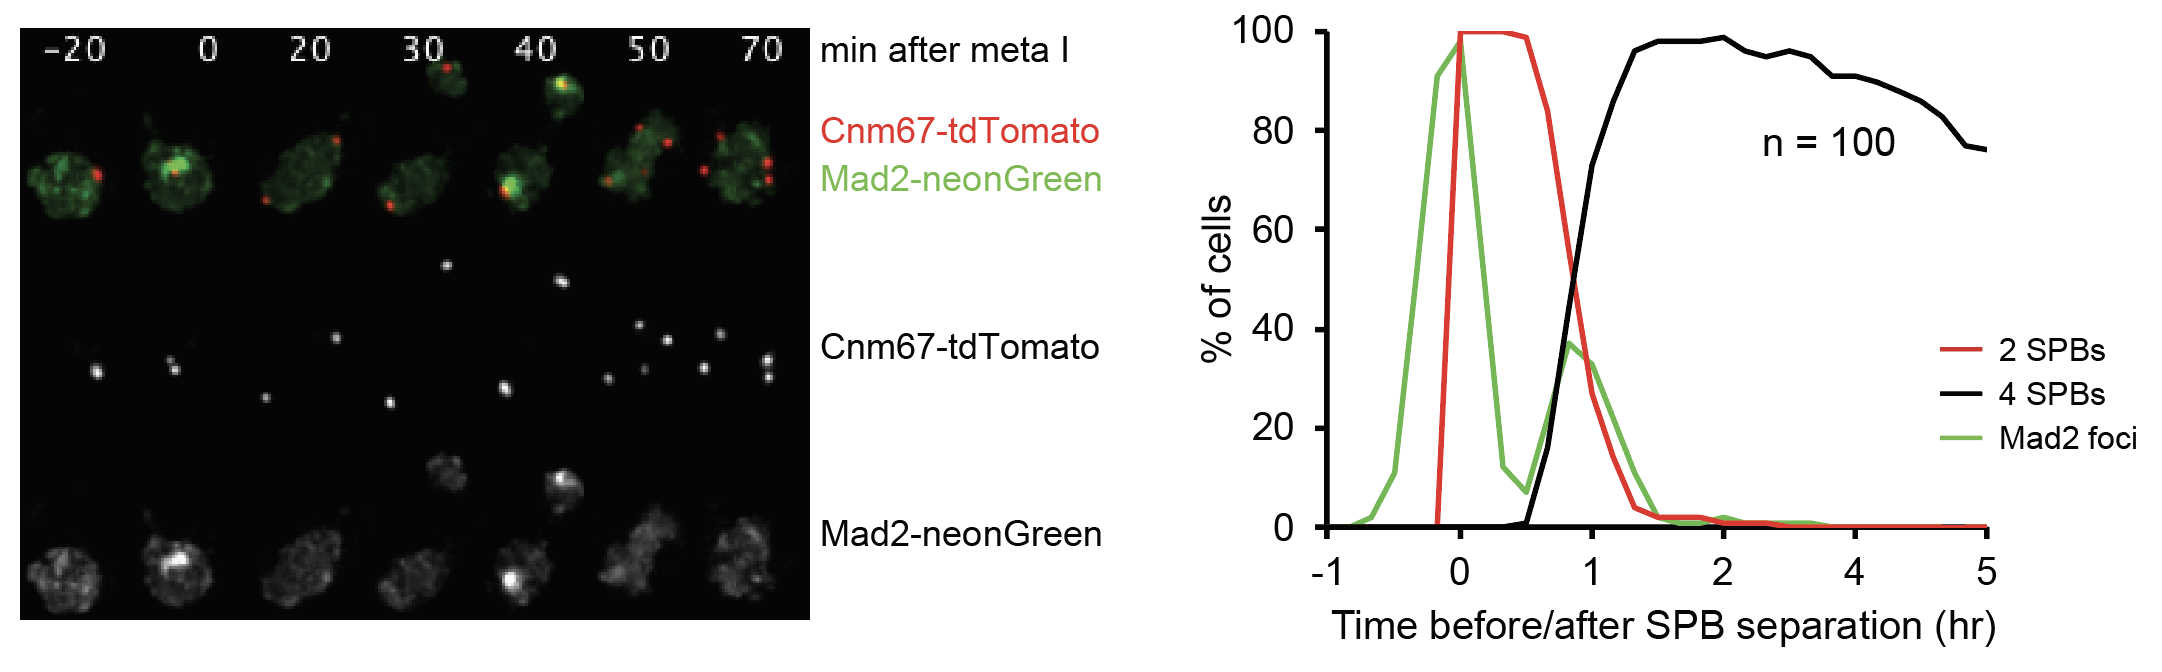

In [5]:
from IPython.display import Image
Image("filming_ex.png")

In [6]:
import mahotas as mh
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact, fixed

plt.rcParams['figure.figsize'] = (8.0, 8.0)

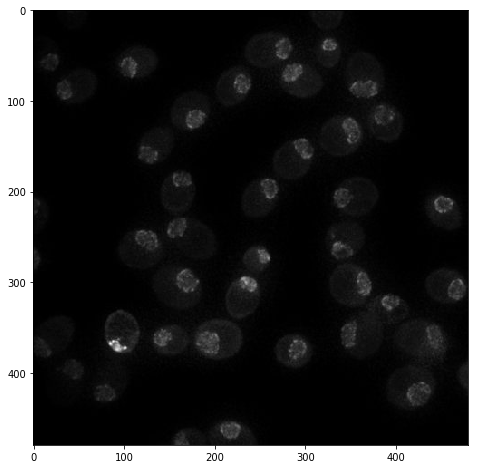

In [7]:
image = mh.imread('mad2ng_ndt80AR/10green05.jpg', as_grey = True)
plt.imshow(image, cmap=plt.cm.gray)  

## Mad2-neonGreen Cell Segmentation

First thing is to find cells and find their position.

To do this, I used (a lot) the mahotas library and tutorial.

Links:

https://mahotas.readthedocs.io/en/latest/labeled.html
    
https://github.com/luispedro/python-image-tutorial/blob/master/Segmenting%20cell%20images%20(fluorescent%20microscopy).ipynb

In [8]:
# This code allows to empirically define the best parameter
@interact(gaus=(1.0,8.0))
def check_gaus(gaus):
    image_gaus = mh.gaussian_filter(image, gaus)
    plt.imshow(image_gaus)
# 3 or 4 should work

interactive(children=(FloatSlider(value=4.5, description='gaus', max=8.0, min=1.0), Output()), _dom_classes=('…

/home/julie/anaconda3/lib/python3.6/site-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


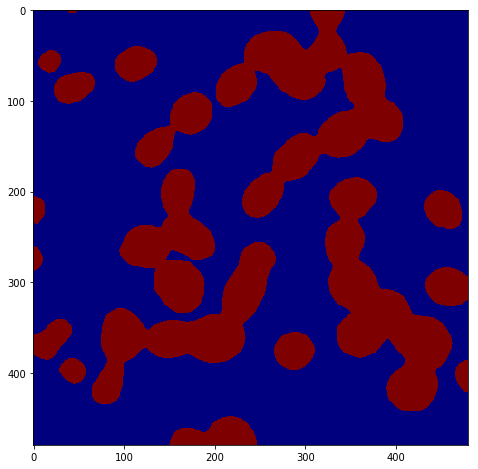

In [9]:
# https://mahotas.readthedocs.io/en/latest/labeled.html 
image_gaus = mh.gaussian_filter(image, 4)
mean = image_gaus.mean()
bin_image = image_gaus > mean*1.2 # Doesn't seem good
plt.imshow(bin_image)
plt.jet()
# Seems like the best threesholding technique, 

In [10]:
# Different threasholds can be used for different purpose (find cells or nuclei)
@interact(thresh=(1,60))
def check_threshold(thresh):
    plt.imshow(image_gaus > thresh)
# With threshold 23, I seems to get most nuclei!
# for full cells, 9-10 is better 

interactive(children=(IntSlider(value=30, description='thresh', max=60, min=1), Output()), _dom_classes=('widg…

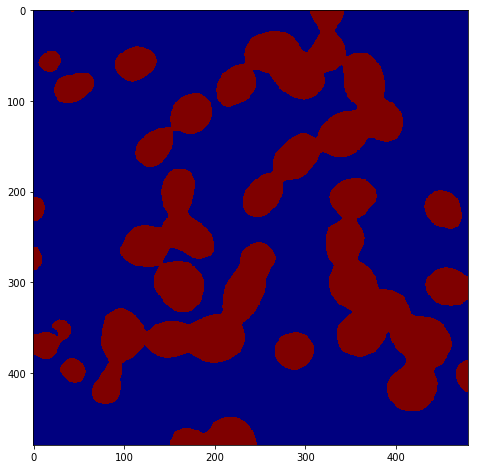

In [11]:
thresholded = image_gaus > 9
plt.imshow(thresholded)

I have 18 nuclei


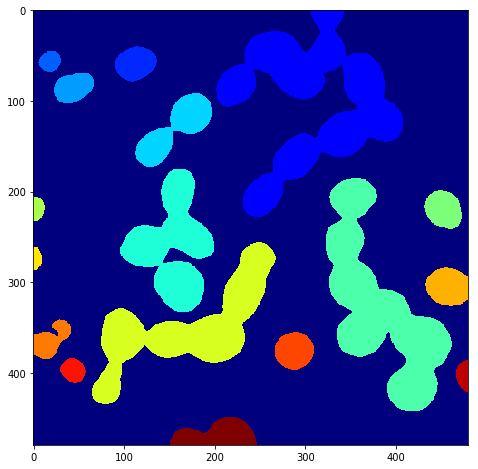

In [12]:
labeled, nr_objects = mh.label(thresholded)
print('I have '+ str(nr_objects) + ' nuclei')

plt.imshow(labeled)
plt.jet()

### The next steps are to separate touching cells

In [13]:
@interact(sigma=(1,16))
def check_sigma(sigma):
    imageG = mh.gaussian_filter(image.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(imageG))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    plt.imshow(mh.as_rgb(np.maximum(255*maxima, imageG), imageG, image > mean))
    # 255 is max for jpg image
# Waouh, that worked surprisingly well !!!
# Sigma of 10 seems best for this picture.

interactive(children=(IntSlider(value=8, description='sigma', max=16, min=1), Output()), _dom_classes=('widget…

/home/julie/anaconda3/lib/python3.6/site-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


Now I got 43 cells


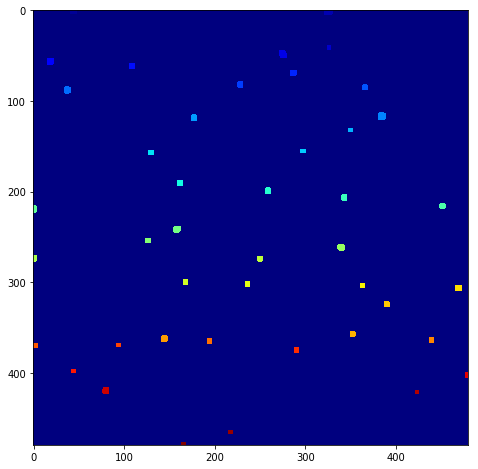

In [14]:
sigma = 10
imageG = mh.gaussian_filter(image.astype(float), sigma)
maxima = mh.regmax(mh.stretch(imageG))
maxima = mh.dilate(maxima, np.ones((5,5)))
maxima,nb_cell= mh.label(maxima)
plt.imshow(maxima)
print('Now I got ' + str(nb_cell) + ' cells')

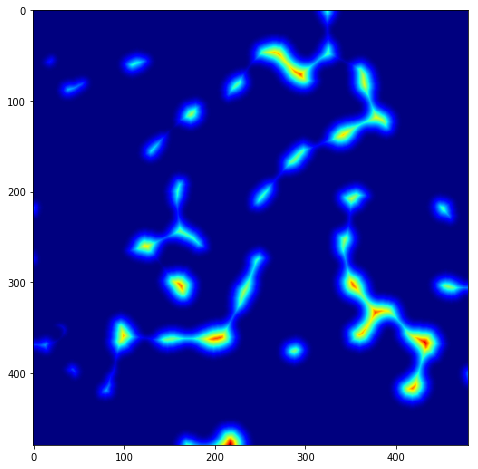

In [15]:
dist = mh.distance(thresholded)
plt.imshow(dist)
# distance transform, What is it for?

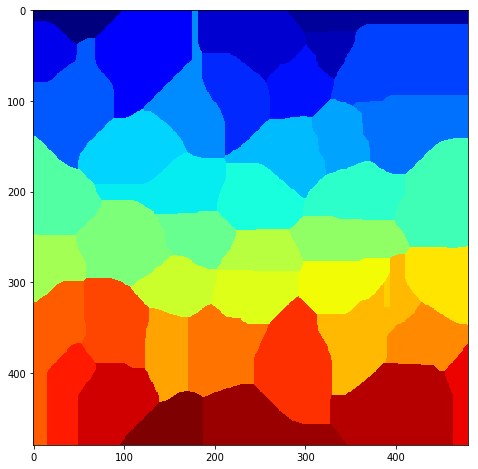

In [16]:
# https://mahotas.readthedocs.io/en/latest/distance.html
dist = 255 - mh.stretch(dist)
watershed = mh.cwatershed(dist, maxima)
plt.imshow(watershed)

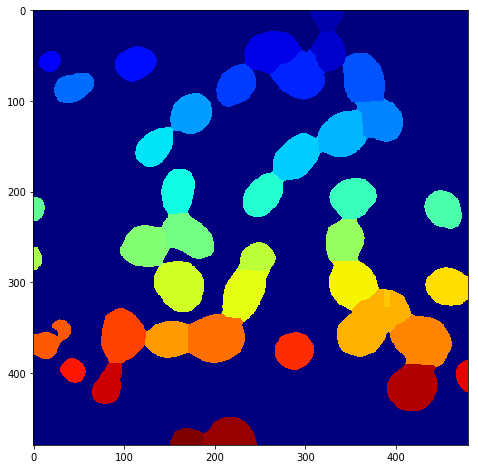

In [17]:
# Take out background 
watershed *= thresholded
plt.imshow(watershed)
# Better but still some improvment to do. 

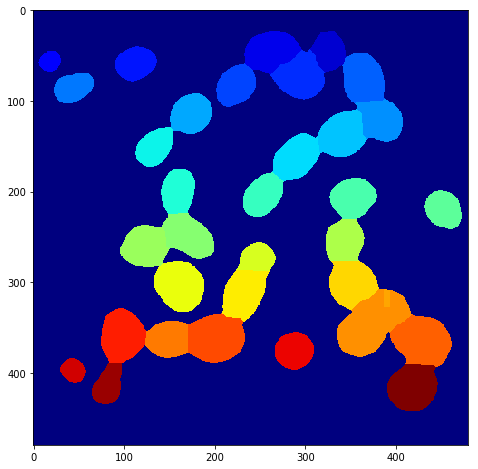

In [18]:
# Take out cells touching borders 
watershed = mh.labeled.remove_bordering(watershed)
plt.imshow(watershed)

In [19]:
# Remove things that are too small to be cells, helper to define best min_size
sizes = mh.labeled.labeled_size(watershed)
watershed = watershed.astype(np.intc)

@interact(min_size=(100,1000,20))
def do_plot(min_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes < min_size)
    print("filtering {}...".format(min_size))
    plt.imshow(filtered)

interactive(children=(IntSlider(value=540, description='min_size', max=1000, min=100, step=20), Output()), _do…

In [20]:
# To define max_size of cells, to eliminate cells that were not separated for instance
sizes = mh.labeled.labeled_size(watershed)
@interact(max_size=(2000,5000,20))
def do_plot(max_size):
    filtered = mh.labeled.remove_regions_where(watershed, sizes > max_size)
    print("filtering {}...".format(max_size))
    plt.imshow(filtered)

interactive(children=(IntSlider(value=3500, description='max_size', max=5000, min=2000, step=20), Output()), _…

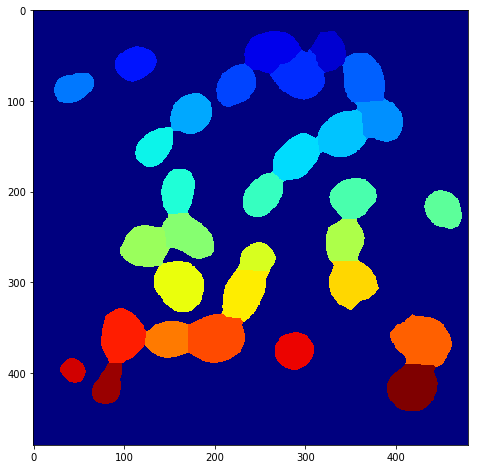

In [21]:
# remove too small and too big regions 
filtered_max = mh.labeled.remove_regions_where(watershed, sizes > 3500)
filtered = mh.labeled.remove_regions_where(filtered_max, sizes < 440)
plt.imshow(filtered)

In [22]:
relabeled, n_left = mh.labeled.relabel(filtered)
print('After filtering and relabeling, there are '+ str(n_left) + ' cells left.')

After filtering and relabeling, there are 31 cells left.


Now that I have labelled nuclei, I should enlarged the zone around each (because they move).
and work on all the time course for cluster detection.
Where do I even start? 

In [23]:
# The bboxes contains the position of each cell
bboxes = mh.labeled.bbox(relabeled, as_slice=False)
#print(bboxes)
#print(len(bboxes))

## Counting of SPBs and Mad2 clusters for each cell and through all time points 

Now that we found were the cells are, we report that information for each time points (separated jpg pictures with ascending number) to follow their progression through meiosis.

However, a big problem is that cells are moving quit a lot... 
So we increase a bit the cell frame and recenter them.

In [24]:
# Smaller picture size 
plt.rcParams['figure.figsize'] = (4.0, 4.0)

### Single cell visualizer (green) 

But first, the next piece of code allow to  simply visualize a specific cell to check what's going on. 

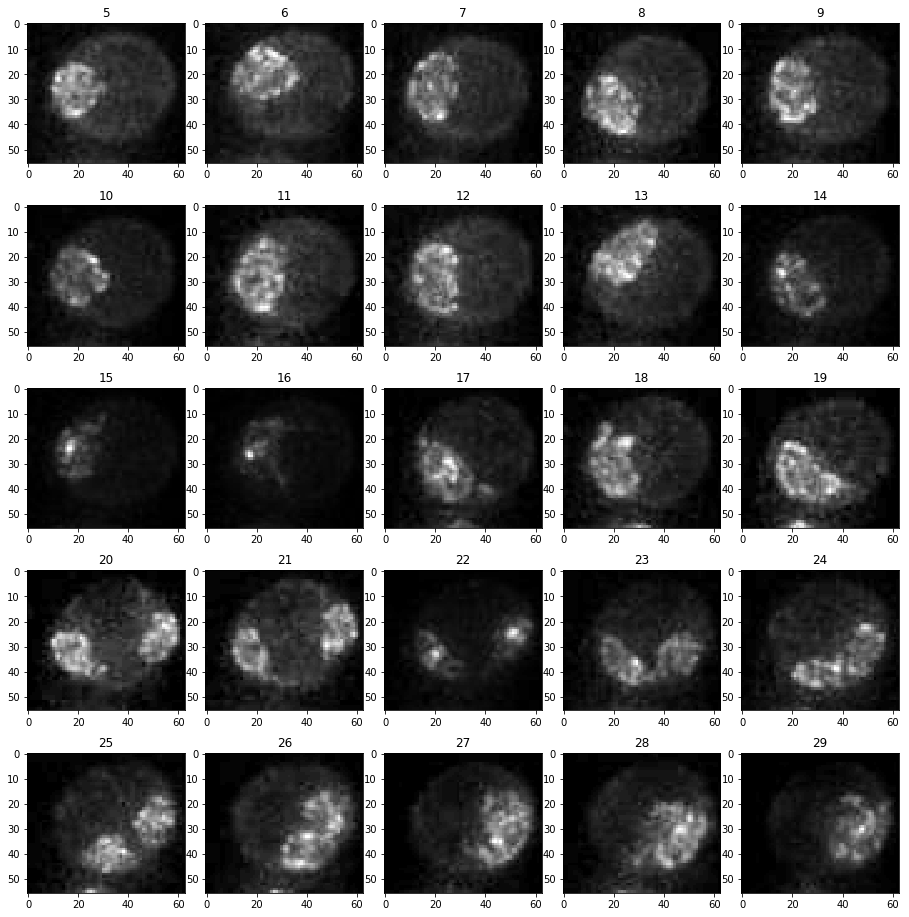

In [25]:
fig, axs = plt.subplots(5,5, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.0001)
axs = axs.ravel()

n = 15 # Write the cell number you want to visualize 
margin = 5 # how much additional space do I want around a cell, to take care of cells moving 
for i in range(5,30):
    if i < 10:
        green = 'mad2ng_ndt80AR/10green0' + str(i) + '.jpg'        
    else:
        green = 'mad2ng_ndt80AR/10green' + str(i) + '.jpg'
    
    image_green = mh.imread(green)
    if bboxes[n][0] < margin:
        a = 0
    else:
        a = bboxes[n][0] - margin
        
    if bboxes[n][1] > (480 + margin):
        b = 0
    else:
        b = bboxes[n][1] + margin
        
    if bboxes[n][2] < margin:
        c = 0
    else:
        c = bboxes[n][2] - margin
        
    if bboxes[n][3] > (480 + margin):
        d = 0
    else:
        d = bboxes[n][3] + margin
    
    #print(str(a) + ' '+ str(b) + ' '+ str(c) + ' '+str(d))
    cell_green = image_green[a:b, c:d]
    
    axs[i-5].imshow(cell_green, cmap=plt.cm.gray)
    axs[i-5].set_title(str(i))

## Single cell visualizer (red) 

Exactly the same for the red channel

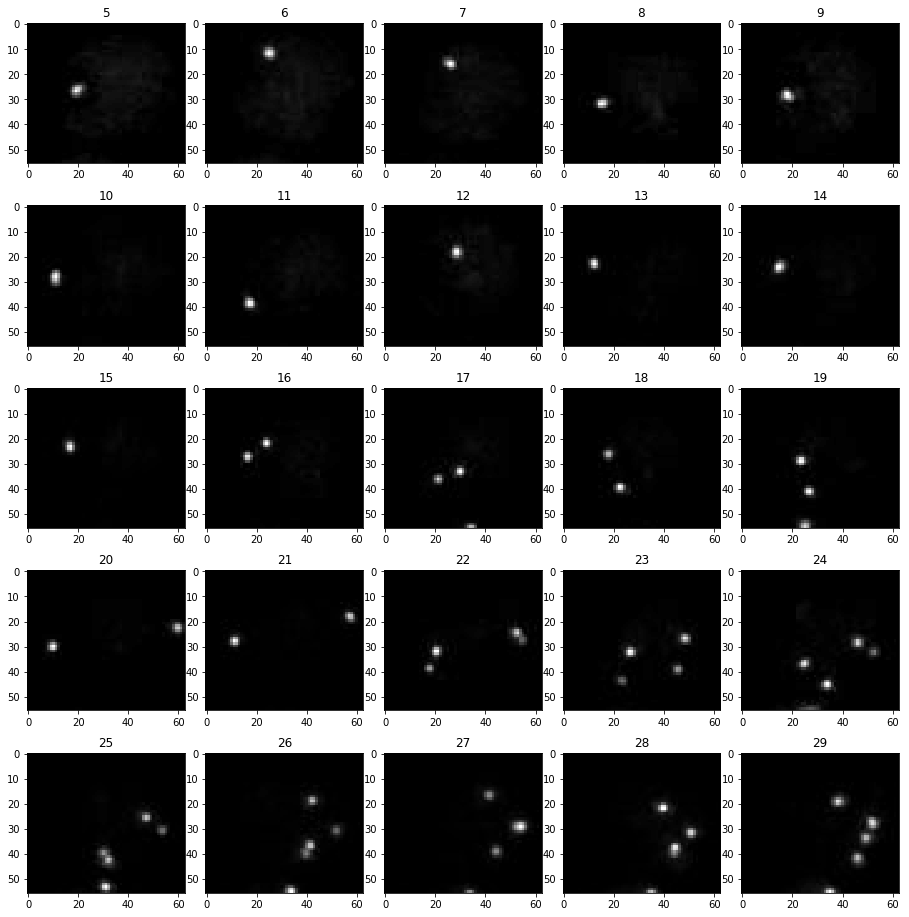

In [26]:
fig, axs = plt.subplots(5,5, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.0001)
axs = axs.ravel()

n = 15 # Write the cell number you want to visualize 
margin = 5 # how much additional space do I want around a cell, to take care of cells moving 
for i in range(5,30):
    if i < 10:
        red = 'mad2ng_ndt80AR/10red0' + str(i) + '.jpg'        
    else:
        red = 'mad2ng_ndt80AR/10red' + str(i) + '.jpg'
    
    image_red = mh.imread(red)
    if bboxes[n][0] < margin:
        a = 0
    else:
        a = bboxes[n][0] - margin
        
    if bboxes[n][1] > (480 + margin):
        b = 0
    else:
        b = bboxes[n][1] + margin
        
    if bboxes[n][2] < margin:
        c = 0
    else:
        c = bboxes[n][2] - margin
        
    if bboxes[n][3] > (480 + margin):
        d = 0
    else:
        d = bboxes[n][3] + margin
    
    #print(str(a) + ' '+ str(b) + ' '+ str(c) + ' '+str(d))
    cell_red = image_red[a:b, c:d]
    axs[i-5].imshow(cell_red, cmap=plt.cm.gray)
    axs[i-5].set_title(str(i))

### Mad2-GFP clusters detection

The next piece of code show how I detect Mad2-GFP cluster formation. 

/home/julie/anaconda3/lib/python3.6/site-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


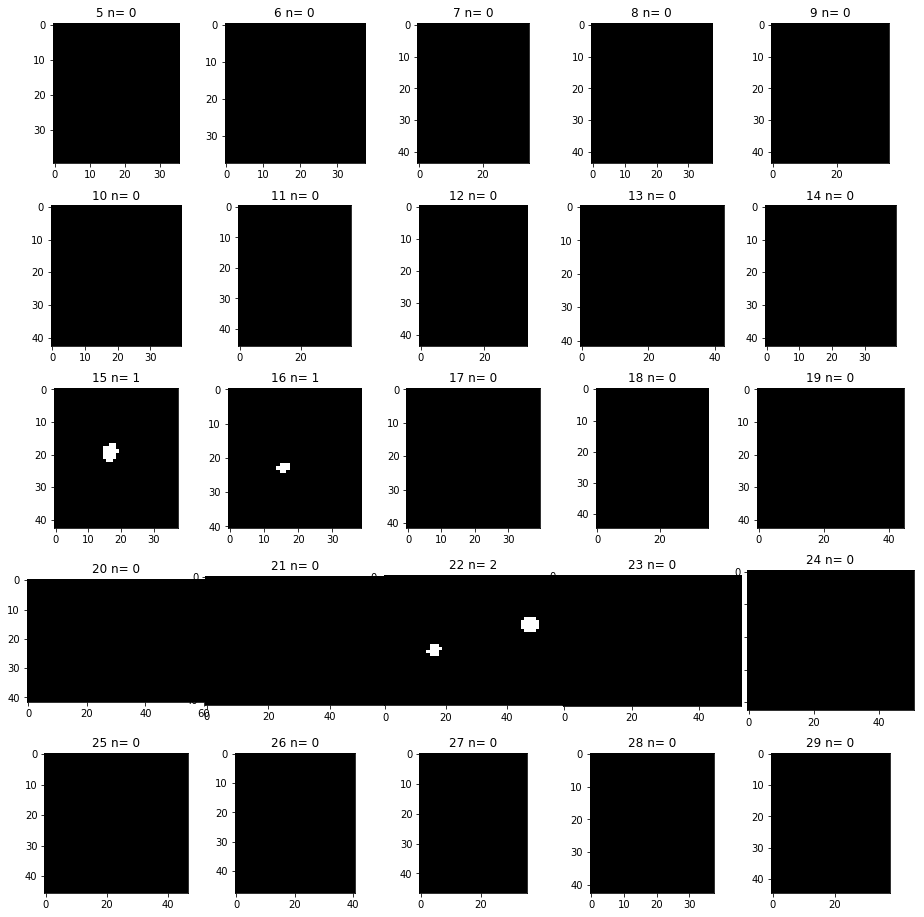

In [27]:
fig, axs = plt.subplots(5,5, figsize=(16,16))
fig.subplots_adjust(hspace = .3, wspace=.0001)
axs = axs.ravel()

n = 15 # Write the cell number you want to visualize 
margin = 5 # how much additional space do I want around a cell, to take care of cells moving 
margC = 10
for i in range(5,30):
    if i < 10:
        green = 'mad2ng_ndt80AR/10green0' + str(i) + '.jpg'    
        red = 'mad2ng_ndt80AR/10red0' + str(i) + '.jpg' 
    else:
        green = 'mad2ng_ndt80AR/10green' + str(i) + '.jpg'
        red = 'mad2ng_ndt80AR/10red' + str(i) + '.jpg' 
    
    image_green = mh.imread(green)
    image_red = mh.imread(red)
    
    if bboxes[n][0] < margin:
        a = 0
    else:
        a = bboxes[n][0] - margin
        
    if bboxes[n][1] > (bboxes[0][1] + margin):
        b = bboxes[0][1]
    else:
        b = bboxes[n][1] + margin
        
    if bboxes[n][2] < margin:
        c = 0
    else:
        c = bboxes[n][2] - margin
        
    if bboxes[n][3] > (bboxes[0][3] + margin):
        d = bboxes[0][3]
    else:
        d = bboxes[n][3] + margin
    
    #print(str(a) + ' '+ str(b) + ' '+ str(c) + ' '+str(d))
    cell_green = image_green[a:b, c:d]
    cell_red = image_red[a:b,c:d]
    image_gaus = mh.gaussian_filter(cell_green, 4)
    #thresholded = image_gaus > 22
    mean = image_gaus.mean()
    thresholded = image_gaus > mean*2.5 # testing wether mean would be better
    # Label cells (nuclei)
    labeled, nr_objects = mh.label(thresholded)
    
    plt.imshow(labeled) ####################
    #plt.jet()
    sigma = 5.0
    # To separate touching cells
    imageG = mh.gaussian_filter(cell_green.astype(float), sigma)
    maxima = mh.regmax(mh.stretch(imageG))
    maxima = mh.dilate(maxima, np.ones((5,5)))
    maxima,_= mh.label(maxima)
    
    # plt.imshow(maxima)
    dist = mh.distance(thresholded)
    dist = 255 - mh.stretch(dist)  
    watershed = mh.cwatershed(dist, maxima)
    watershed *= thresholded
    # To remove nuclei touching border, essential for my problem of cells entering the field selected!!!
    watershed = mh.labeled.remove_bordering(watershed)
    # filtered if too small to be a full nuclei
    #filtered = mh.labeled.remove_regions_where(watershed, sizes < 100)
    # Now I should only have one cells (with 1, 2 or 4 nuclei)
    relabeled, n_left = mh.labeled.relabel(watershed)
    #relabeled = mh.dilate(relabeled)
    #relabeled = mh.dilate(relabeled)
    loc = mh.labeled.bbox(relabeled, as_slice=False) 
    # Want to merge the spot identified and add a margin
    #print(loc)
    a = loc[0][1]
    b = 0
    c = loc[0][3]
    d = 0
    if len(loc) == 1:
        a = loc[0][0]
        b = loc[0][1]
        c = loc[0][2]
        d = loc[0][3]
    if len(loc) == 2:
        a = loc[1][0]
        b = loc[1][1]
        c = loc[1][2]
        d = loc[1][3]
    else:
        for m in range(1,len(loc)):
            if loc[m][0] < a:
                a = loc[m][0]
            if loc[m][1] > b:
                b = loc[m][1]
            if loc[m][2] < c:
                c = loc[m][2]
            if loc[m][3] > d:
                d = loc[m][3]
        
    if a < margC:
        a = 0
    else:
        a -= margC

    if b > (loc[0][1] + margC):
        b = loc[0][1]
    else:
        b += margC

    if c < margC:
        c = 0
    else:
        c -= margC

    if d > (loc[0][3] + margC):
        d = loc[0][3]
    else:
        d += margC
   
    cell_green = cell_green[a:b,c:d]
    cell_red = cell_red[a:b,c:d]
    
    # MAD2 CLUSTERS DETECTION
    green_gaus = mh.gaussian_filter(cell_green, 1.7)
    mean = green_gaus.mean()
    bin_green = green_gaus > mean*5
    cluster, nb_clust = mh.label(bin_green)
    # size exclusion?
    axs[i-5].imshow(bin_green, cmap=plt.cm.gray)
    axs[i-5].set_title(str(i) + ' n= ' + str(nb_clust))
    
    red_Thr = cell_red > 20
    spbs, nb_spb = mh.label(red_Thr)
    
    maxima = mh.regmax(mh.stretch(cell_red))
    #maxima = mh.dilate(maxima, np.ones((5,5)))
    #axs[i].imshow(mh.as_rgb(np.maximum(maxima, cell_red), cell_red, cell_red > 20))
    
    # To separate touching SPBs, works well!
    maxima,_= mh.label(maxima)
    dist = mh.distance(red_Thr)
    dist = 255 - mh.stretch(dist) # What does this 255 correspond to? 
    cell_water= mh.cwatershed(dist, maxima)
    cell_water *= red_Thr
    relab_cell, spb_sep = mh.labeled.relabel(cell_water)
    
    #axs[i].imshow(cell_water, cmap=plt.cm.gray)
    #axs[i].set_title(str(i) + ' n= ' + str(spb_sep))
    
    #axs[i].imshow(spbs, cmap=plt.cm.gray)
    #axs[i].set_title(str(i) + ' n= ' + str(nb_spb))
    
    #axs[i].imshow(cell_green, cmap=plt.cm.gray)
    #axs[i].imshow(cell_red, cmap=plt.cm.gray)
    #axs[i].imshow(relabeled, cmap=plt.cm.gray)
    #axs[i].set_title(str(i) + ' n= ' + str(n_left))

### Countings of SPBs and Mad2 clusters in each frame, and each cell

We store the number of detected SPBs and Mad2 clusters for each time point (list) and each cell (list of list)

In [28]:
SPB = []
clusters = []
margin = 5
margC = 10
for n in range(1,len(bboxes)): # for each cell, 0 is background so we start at 1 
    SPBcount = []
    cluster_count = []
    for m in range(5, 28): # for each frame
        if m < 10:
            red = 'mad2ng_ndt80AR/10red0' + str(m) + '.jpg'
            green = 'mad2ng_ndt80AR/10green0' + str(m) + '.jpg'
        else:
            red = 'mad2ng_ndt80AR/10red' + str(m) + '.jpg'
            green = 'mad2ng_ndt80AR/10green' + str(m) + '.jpg'
            
        image_red =  mh.imread(red, as_grey = True)
        image_green = mh.imread(green, as_grey = True)
        
        # increase space around cell to cope with cell moving (margin)
        if bboxes[n][0] < margin:
            a = 0
        else:
            a = bboxes[n][0] - margin
        
        if bboxes[n][1] > (bboxes[0][1] + margin):
            b = bboxes[0][1]
        else:
            b = bboxes[n][1] + margin
        
        if bboxes[n][2] < margin:
            c = 0
        else:
            c = bboxes[n][2] - margin
        
        if bboxes[n][3] > (bboxes[0][3] + margin):
            d = bboxes[0][3]
        else:
            d = bboxes[n][3] + margin
        
        cell_red = image_red[a:b, c:d]
        cell_green = image_green[a:b, c:d]
        
        image_gaus = mh.gaussian_filter(cell_green, 4)
        #thresholded = image_gaus > 22
        mean = image_gaus.mean()
        thresholded = image_gaus > mean*2
        
        # Detect were is the cell to recenter it 
        labeled, nr_objects = mh.label(thresholded)
        sigma = 5.0
        imageG = mh.gaussian_filter(cell_green.astype(float), sigma)
        maxima = mh.regmax(mh.stretch(imageG))
        maxima = mh.dilate(maxima, np.ones((5,5)))
        maxima,_= mh.label(maxima)
        dist = mh.distance(thresholded)
        dist = 255 - mh.stretch(dist) # What does this 255 correspond to? 
        watershed = mh.cwatershed(dist, maxima)
        watershed *= thresholded
        watershed = mh.labeled.remove_bordering(watershed)
        relab_cell, n_left = mh.labeled.relabel(watershed)
        loc = mh.labeled.bbox(relab_cell, as_slice=False) # Carefull, index 0 is always background
        # Add some margin (margC)
        a = loc[0][1]
        b = 0
        c = loc[0][3]
        d = 0 
        if len(loc) == 1:
            a = loc[0][0]
            b = loc[0][1]
            c = loc[0][2]
            d = loc[0][3]
        if len(loc) == 2:
            a = loc[1][0]
            b = loc[1][1]
            c = loc[1][2]
            d = loc[1][3]
        else:
            for m in range(1,len(loc)):
                if loc[m][0] < a:
                    a = loc[m][0]
                if loc[m][1] > b:
                    b = loc[m][1]
                if loc[m][2] < c:
                    c = loc[m][2]
                if loc[m][3] > d:
                    d = loc[m][3]

        if a < margC:
            a = 0
        else:
            a -= margC

        if b > (loc[0][1] + margC):
            b = loc[0][1]
        else:
            b += margC

        if c < margC:
            c = 0
        else:
            c -= margC

        if d > (loc[0][3] + margC):
            d = loc[0][3]
        else:
            d += margC
        
        nucl = cell_red[a:b,c:d]
        nucl_Thr = nucl > 30
        spbs, nb_spb = mh.label(nucl_Thr)
        maxima = mh.regmax(mh.stretch(nucl))
        #maxima = mh.dilate(maxima, np.ones((5,5)))
        #axs[i].imshow(mh.as_rgb(np.maximum(maxima, cell_red), cell_red, cell_red > 20))
        
        # Now counting mad2-neonGreen clusters 
        Green = cell_green[a:b,c:d]
        green_gaus = mh.gaussian_filter(Green, 1.5)
        mean = green_gaus.mean()
        bin_green = green_gaus > mean*5
        cluster, nb_clust = mh.label(bin_green)
        cluster_count.append(nb_clust)
        
        # To separate touching SPBs, works well!
        maxima,_= mh.label(maxima)
        dist = mh.distance(nucl_Thr)
        dist = 255 - mh.stretch(dist) # What does this 255 correspond to? 
        red_water= mh.cwatershed(dist, maxima)
        red_water *= nucl_Thr
        relab_red, spb_sep = mh.labeled.relabel(red_water)
        SPBcount.append(spb_sep)
    
    SPB.append(SPBcount)
    clusters.append(cluster_count)
    print('cell number: ' + str(n))
    print(SPBcount)
    print(cluster_count)

/home/julie/anaconda3/lib/python3.6/site-packages/mahotas/internal.py:112: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(A.dtype, np.float):


cell number: 1
[1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 1, 3, 2, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0]
cell number: 2
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
cell number: 3
[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0]
cell number: 4
[2, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
cell number: 5
[1, 1, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 3, 3, 3, 3, 4, 3, 3, 4, 5, 4, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
cell number: 6
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 5, 4, 4, 4, 3, 4]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1]
cell number: 7
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1, 

### Remove abnormal cells

We shall remove cells that do not progress (stay with one SPBs), dead cells (typically brighter, they have high number of "SPBs"). 

Additionally, cells start with 1 SPBs, then get 2, then 4. When cells are too close from each other, I might wrongly count SPBs belonging to neighbouring cells. These results in aberrant SPBs counting. These cells are also removed. 

In [29]:
# This code clean up a bit SPBs data according to what's before and after 

clean_SPB = []

for x in range(len(SPB)):
    spb = SPB[x]
    new_spb = [1]
    for y in range(1,len(spb)-1):
        s = 0
        if spb[y+1] <= 1 and new_spb[y-1] <= 1:
            s = 1
        elif spb[y+1] == 2 and new_spb[y-1] == 2:
            s = 2
        elif spb[y+1] == 4 and new_spb[y-1] == 4:
            s = 4
        elif spb[y] == 2 and spb[y+1] >= 2:
            s = 2
        elif spb[y+1] > 2 and new_spb[y-1] > 2:
            s = 4
        elif spb[y] > 2 and new_spb[y-1] > 2:
            s = 4
        elif spb[y] >= 4 or spb[y] > 2:
            s = 4
        elif spb[y] < 2:
            s = 1
        else:
            s = 2
        
        new_spb.append(s)
    clean_SPB.append(new_spb)
    #print(x)
    #print(spb)
    #print(new_spb)
#print(clean_SPB)

In [30]:
# Now that I did what I could for cleaning up SPBs, 
# I need to exclude cells that still don't behave

# Meaning, cells that never enter meiosis (2 SPBs)
# Plus, x has to be <= x+1

# Boolean, if cells is fine: True, else: False 
Good_cells = []
for x in range(len(clean_SPB)):
    cell = clean_SPB[x]
    good = True
    for y in range(len(cell)-1):
        if cell[y] > cell[y+1]:
            good = False
        if cell[y] == 1 and cell[y+1] == 4:
            good = False
        if max(cell) == 1:
            good = False
    Good_cells.append(good)
#print(Good_cells)

In [31]:
good_cells_spb = []
Good_Green = []
for x in range(len(clean_SPB)):
    if Good_cells[x] == True:
        good_cells_spb.append(clean_SPB[x])
        Good_Green.append(clusters[x])
        #print(clean_SPB[x])
        #print(clusters[x])
#print(good_cells_spb)

In [32]:
# Now I just have to add this up

two_spbs = [0] * len(good_cells_spb[0])
four_spbs = [0] * len(good_cells_spb[0])
mad2_clust = [0] * len(good_cells_spb[0])
for x in range(len(good_cells_spb)):
    cell = good_cells_spb[x]
    clust = Good_Green[x]
    for y in range(len(cell)):
        if clust[y] > 0:
            mad2_clust[y] += 1
        if cell[y] == 2:
            two_spbs[y] += 1
        if cell[y] == 4:
            four_spbs[y] += 1

#print(two_spbs)
#print(four_spbs)
#print(mad2_clust)

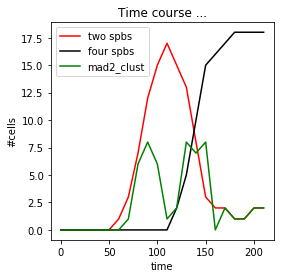

Total number of quantified cells: 20


In [38]:
# Now the plotting!
m = len(two_spbs)*10
x_axis = list(range(0,m, 10))

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(x_axis, two_spbs,color='r',label='two SPBss')
ax.plot(x_axis, four_spbs,color='k',label='four SPBss')
ax.plot(x_axis, mad2_clust,color='g',label='mad2 cluster')
plt.xlabel("time (min)")
plt.ylabel("# cells")
plt.title("Time course ...")
ax.legend()
plt.show()
print('Total number of quantified cells: ' + str(len(good_cells_spb)))

# PRETTY GOOD! I'M SOOO HAPPY! 

### In silico synchronization 

I now want to synchronize, in silico, my countings to the appearance of 2 SPBs.

In [40]:
sync_spbs_cells = []
sync_mad2_cells = []
for x in range(len(good_cells_spb)):
    cell = good_cells_spb[x]
    clust = Good_Green[x]
    sync_spbs = [0] * len(cell)
    sync_Green = [0] * len(cell)
    y = 0
    while cell[y] == 1:
        y += 1 
        if y > len(cell):
            break
    for z in range(y,len(cell)):
        sync_spbs[z-y+3] = cell[z] # The +3 is there for esthetic region on the graph
        sync_Green[z-y+3] = clust[z]
    sync_spbs_cells.append(sync_spbs)
    sync_mad2_cells.append(sync_Green)
    #print(cell)
    #print(sync_spbs)
    #print(sync_Green)
    #print()
        

In [41]:
# Because of synchronizations the four SPBs drop at some point (when list is over) but it does not make sense, 
# so once we have 4 spbs, we keep it at 4

sync_spbs_corrected = []
for x in range(len(sync_spbs_cells)):
    cell = sync_spbs_cells[x]
    for y in range(1,len(cell)):
        if cell[y-1] == 4:
            cell[y] = 4
    sync_spbs_corrected.append(cell)


In [42]:
two_sync = [0] * len(sync_spbs_corrected[0])
four_sync = [0] * len(sync_spbs_corrected[0])
mad2_sync = [0] * len(sync_spbs_corrected[0])
for x in range(len(sync_spbs_corrected)):
    cell = sync_spbs_corrected[x]
    clust = sync_mad2_cells[x]
    for y in range(len(cell)):
        if clust[y] > 0:
            mad2_sync[y] += 1
        if cell[y] == 2:
            two_sync[y] += 1
        if cell[y] == 4:
            four_sync[y] += 1
#print(mad2_sync)
#print(two_sync)
#print(four_sync)



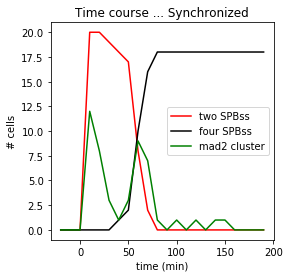

Total number of quantified cells: 20


In [45]:
# Now the plotting!
new_x = []
for x in range(len(x_axis)):
    new_x.append(x_axis[x]-20)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(new_x, two_sync, color='r',label='two SPBss')
ax.plot(new_x, four_sync, color='k',label='four SPBss')
ax.plot(new_x, mad2_sync, color='g',label='mad2 cluster')
plt.xlabel("time (min)")
plt.ylabel("# cells")
plt.title("Time course ... Synchronized")
ax.legend()
plt.show()

print('Total number of quantified cells: ' + str(len(good_cells_spb)))

# Looks very similar to manual counting :)

## Next steps

The next step is to modify the previous code to make a python script that would iter through all the field of view recorded to quantify more than a 100 cells.

The Mad2nG_ndt80_analysis.py file goes through all the frame to obtain countings with more than a 100 cells. It is a modified version of the python notebook.

Running the script will create two .png files: Not_synchronized.png graph that display the countings of spindle pole bodies (SPBs) and Mad2-nG countings and synchronized.png that display the "in silico" synchronized countings to the apparition of 2 SPBs. It fit quit well the manual countings. Although I would need to count manually the cells detected and analyzed to give an exact accuracy %. 